# Deep Learning for Computer Vision:  HW 3


## Computer Science: COMS W 4995 006


### Due: October 20, 2022

#### Problem

a) You are given two dimensional input from three separate classes. Your task is to implement a multi-layer perceptron (MLP) 3-class classifier with multiple hidden layers and a regularization on the weights. For the activiation function of the hidden units use ReLU or leaky ReLU. For the predictions use softmax on a linear output layer as we did in class. Your loss layer should compute $-\log P(y = i \,|{\bf x})$ where $i$ is the correct label according to the training data.

Implement each layer type (hidden, output, and loss) as separate python classes, each with methods for initialization, forward propagation, and backpropagation.

Implement a MLP as its own class, with separate methods for initialization, adding a layer, forward propagation, backpropagation, training and prediction. 

Let the layer dimensions be parameters passed when the network is created.

Let the number of training epochs, the mini-batch size, and the regularization parameter be parameters that are passed when training the network.

Build and run your network using your own constructs. The code for doing this might look like what is shown in the next box below.

b) Show the decision regions of the trained classifier by densely generating points in the plane and color coding these points with the three different labels. 

c) Repeat varying the number of hidden units (3, 8, 16), the number of hidden layers (1 and 3), and the regularization value (0 and some other value of your choosing).

d) Re-use this same network on any data of your own choosing. You can increase the dimensionality of the features space as you like. You can also change the number of classes to just two or more than three to align with your data. Separate your data into three piles: training, testing, and validation. Use your validation data to decide when to stop training if appropriate. Use your testing set to compute the accuracy of you classfier. 

In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
## Hidden Layer Class Definition ##
class hiddenLayer:
    def __init__(self,dim_in,dim_out,dS):
        self.dim_in = dim_in
        self.dim_out = dim_out
        self.W = 2*np.random.rand(dim_in,dim_out)-1
        self.c = 2*np.random.rand(dim_out,1)-1
        self.dS = dS   # learning rate
        self.LgradWVec = []
        self.LgradcVec = []
    
    def ReLU(self,z):
        return np.maximum(z,0)
    
    def f(self,z):
        return np.where(z < 0, 0, 1)
    
    def forward(self,h,x,y):
        self.h = h
        self.u = np.matmul(self.W.transpose(),h) + self.c
        self.z = self.ReLU(self.u)
        return self.z
    
    def backward(self,x,y,Lgradh,alpha):
        # Get output gradients
        LgradW = self.h * np.multiply(self.f(self.u),Lgradh).transpose()
        LgradW += alpha * self.W # regularization
        Lgradc = np.multiply(self.f(self.u),Lgradh)
        Lgradc += alpha * self.c # regularization
        
        # Add output gradients to current batch
        self.LgradWVec.append(LgradW)
        self.LgradcVec.append(Lgradc)

        return Lgradh
    
    def update(self,bsize):
        self.W = self.W - self.dS * np.mean(self.LgradWVec,axis=0)
        self.c = self.c - self.dS * np.mean(self.LgradcVec,axis=0)
        
        self.LgradWVec = []
        self.LgradcVec = []
            

In [3]:
## Output Layer Class Definition ##
class outputLayer:
    def __init__(self,dim_in,dim_out,dS):
        self.dim_in = dim_in
        self.dim_out = dim_out
        self.w = 2*np.random.rand(dim_in,dim_out)-1
        self.b = 2*np.random.rand(dim_out,1)-1
        self.dS = dS   # learning rate
        self.LgradwVec = []
        self.LgradbVec = []
        
    def forward(self,h,x,y):
        self.h = h
        self.z = np.matmul(self.w.transpose(),h) + self.b
        return self.z
    
    def backward(self,x,y,Lgradz,alpha):
        # Get gradients
        Lgradh = np.matmul(self.w,Lgradz)
        Lgradw = np.matmul(self.h,Lgradz.transpose())
        Lgradw += alpha * self.w # regualrization
        Lgradb = Lgradz
        Lgradb += alpha * self.b # regualrization
        
        # Add output gradients to current batch
        self.LgradwVec.append(Lgradw)
        self.LgradbVec.append(Lgradb)
        
        return Lgradh
    
    def update(self,bsize):
        self.w = self.w - self.dS * np.mean(self.LgradwVec,axis=0)
        self.b = self.b - self.dS * np.mean(self.LgradbVec,axis=0)
        
        self.LgradwVec = []
        self.LgradbVec = []
        

In [4]:
## Loss Layer Class Definition ##
class lossLayer:
    def __init__(self,dim_in,dim_out,dS):
        self.dim_in = dim_in
        self.dim_out = dim_out
        self.dS = dS
        self.units = self.dim_in
        #self.w = np.random.rand(dim_in,dim_out)
        #self.b = np.random.rand(dim_out,1)
        #self.dS = dS   # learning rate
    
    def zeta(self,r):
        # Return softplus values
        return np.log(1+np.exp(r))
    
    def loss(self,z,y):
        # Loss function: zeta/softplus
        return self.zeta((1-2*y)*z)
    
    def predict(self,z):
        maxIdx = 0
        maxVal = z[0]
        for i in range(len(z)):
            if(z[i] > maxVal):
                maxVal = z[i]
                maxIdx = i
        
        return maxIdx
    
    def forward(self,z,x,y):
        self.z = z
        return (self.predict(z),self.loss(z,y)) # tuple (prediction,loss)
    
    def backward(self,x,y):
        Lgradz = np.zeros(self.units,dtype=float)
        
        # Build gradient
        zSum = sum(np.exp(self.z))
        Lgradz = np.exp(self.z)/zSum
        
        # Subtract one from the correct class
        Lgradz[int(y)] -= 1
        
        return Lgradz
    
    #def update(self,Lgradw,Lgradb):
    #    self.w = self.w - self.dS * Lgradw
    #    self.b = self.b - self.dS * Lgradb
        

In [5]:
class MLP:
    def __init__(self):
        self.dS = 10**(-3)
        self.layers = []
        self.lastPercentCorrect = 0
    
    def add_layer(self,layerType,dim_in,dim_out):
        if layerType == 'Hidden':
            layerObj = hiddenLayer(dim_in,dim_out,self.dS)
        elif layerType == 'Output':
            layerObj = outputLayer(dim_in,dim_out,self.dS)
        elif layerType == 'Loss':
            layerObj = lossLayer(dim_in,dim_out,self.dS)
        else:
            print('Error: Invalid layer passed')
            return
        
        self.layers.append(layerObj)
        
    def predict(self,x):
        curX = x
        curY = 0 # placeholder
        #curX = curX.transpose()

        # Forward Pass:
        curVal = curX
        for j in range(len(self.layers)):
            curVal = self.layers[j].forward(curVal,curX,curY)

        # Prediction
        return curVal[0]
    
    def validationTest(self,X,y):
        numCorrect = 0
        totalNum = np.shape(X)[0]
        
        for i in range(totalNum):
            curX = np.asarray(X[i],dtype=float)
            curY = y[i].item()
            curX = curX.transpose()
            
            yPredict = self.predict(curX)
            
            if yPredict == curY:
                numCorrect+=1
        
        curPercentRight = numCorrect/totalNum
        
        if curPercentRight > self.lastPercentCorrect or curPercentRight < .95:
            self.lastPercentCorrect = curPercentRight
            
            #for j in range(len(self.layers)):
            #    curVal = self.layers[j].saveCurWeights()
            
            return False # keep going
        else: # we are done!
            self.lastPercentCorrect = curPercentRight
            return True # end here
            
        
        
    
    def train(self,X, y, epochs, bsize, alpha,validateData = False,validationDataX = [],validationDataY = []):
        curSamplesInBatch = 0
        for curEpoch in range(epochs):
            for i in range(np.shape(X)[0]):
                curX = np.asarray(X[i],dtype=float)
                curY = y[i].item()
                curX = curX.transpose()

                # Forward Pass:
                curVal = curX
                for j in range(len(self.layers)):
                    curVal = self.layers[j].forward(curVal,curX,curY)
                
                # Loss & Regularization (L2)
                loss = curVal[1]
                regularization = 0
                
                # Hidden Layer Regularization
                for j in range(len(self.layers)-2):
                    regularization += np.linalg.norm(self.layers[j].W)**2 + np.linalg.norm(self.layers[j].c)**2
                    
                # Output Layer Regularization
                regularization += np.linalg.norm(self.layers[-2].w)**2 + np.linalg.norm(self.layers[-2].b)**2
                
                # Finalize Regularization
                regularization *= alpha/2
                
                
                # Backward Pass - Loss Layer
                lossLayer = self.layers[-1]
                gradPass = lossLayer.backward(curX,curY)

                # Backward Pass - Output/Hidden Layers
                for j in reversed(range(len(self.layers)-1)):
                    gradPass = self.layers[j].backward(curX,curY,gradPass,alpha)
                
                # Batches & Updating
                curSamplesInBatch += 1
                if curSamplesInBatch % bsize == 0:
                    # Update all layers
                    curSamplesInBatch = 0
                    for j in range(len(self.layers)-1):
                        self.layers[j].update(bsize)
                        
            # After 50% of epochs have finished, do validation tests
            if validateData and curEpoch > epochs/2:
                finishNow = self.validationTest(validationDataX,validationDataY)
                if finishNow:
                    return
                
                    
                

 

#### NOTE:  Do not to use keras, tensorflow, pytorch, sklearn, etc. to do this.  You must build the machine learning components from scratch.  

#### YOUR CODE MUST BE YOUR OWN.
_______________________________________________________________



Let's start by importing some libraries.

Let's make up our 2D data for our three classes.

In [6]:
data = pd.DataFrame(np.zeros((5000, 3)), columns=['x1', 'x2', 'y'])

# Let's make up some noisy XOR data to use to build our binary classifier
for i in range(len(data.index)):
    x1 = random.randint(0,1)
    x2 = random.randint(0,1)
    if x1 == 1 and x2 == 0:
        y = 0
    elif x1 == 0 and x2 == 1:
        y = 0
    elif x1 == 0 and x2 == 0:
        y = 1
    else:
        y = 2
    x1 = 1.0 * x1 + 0.20 * np.random.normal()
    x2 = 1.0 * x2 + 0.20 * np.random.normal()
    data.iloc[i,0] = x1
    data.iloc[i,1] = x2
    data.iloc[i,2] = y
    
for i in range(int(0.25 *len(data.index))):
    k = np.random.randint(len(data.index)-1)  
    data.iloc[k,0] = 1.5 + 0.20 * np.random.normal()
    data.iloc[k,1] = 1.5 + 0.20 * np.random.normal()
    data.iloc[k,2] = 1

for i in range(int(0.25 *len(data.index))):
    k = np.random.randint(len(data.index)-1)  
    data.iloc[k,0] = 0.5 + 0.20 * np.random.normal()
    data.iloc[k,1] = -0.75 + 0.20 * np.random.normal()
    data.iloc[k,2] = 2
    
# Now let's normalize this data.
data.iloc[:,0] = (data.iloc[:,0] - data['x1'].mean()) / data['x1'].std()
data.iloc[:,1] = (data.iloc[:,1] - data['x2'].mean()) / data['x2'].std()
        
data.head()

,x1,x2,y
0,-0.118007,0.808832,0.0
1,-1.215711,-0.668006,1.0
2,-0.080314,-1.251889,2.0
3,-1.633379,0.733003,0.0
4,0.155580,-0.195699,0.0


Let's message this data into a numpy format.

In [7]:
# set X (training data) and y (target variable)
cols = data.shape[1]
X = data.iloc[:,0:cols-1]
y = data.iloc[:,cols-1:cols]

# The cost function is expecting numpy matrices so we need to convert X and y before we can use them.  
X = np.matrix(X.values)
y = np.matrix(y.values)

Let's make a sloppy plotting function for our binary data.

In [8]:
# Sloppy function for plotting our data
def plot_data(X, y_predict):
    
    fig, ax = plt.subplots(figsize=(12,8))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

    indices_0 = [k for k in range(0, X.shape[0]) if y_predict[k] == 0]
    indices_1 = [k for k in range(0, X.shape[0]) if y_predict[k] == 1]
    indices_2 = [k for k in range(0, X.shape[0]) if y_predict[k] == 2]
    indices_3 = [k for k in range(0, X.shape[0]) if y_predict[k] == 3]

    ax.plot(X[indices_0, 0], X[indices_0,1], marker='o', linestyle='', ms=5, label='0')
    ax.plot(X[indices_1, 0], X[indices_1,1], marker='o', linestyle='', ms=5, label='1')
    ax.plot(X[indices_2, 0], X[indices_2,1], marker='o', linestyle='', ms=5, label='2')
    ax.plot(X[indices_3, 0], X[indices_3,1], marker='o', linestyle='', ms=5, label='3')

    ax.legend()
    ax.legend(loc=2)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title('Tricky Class Classification')
    plt.show()

Now let's plot it.

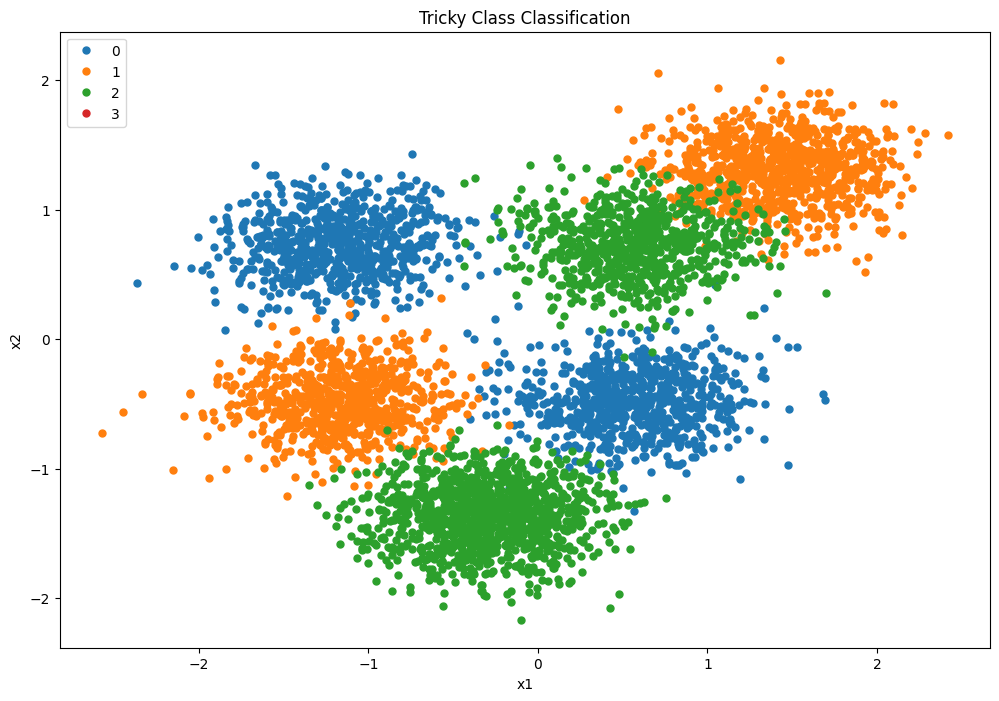

In [9]:
plot_data(X, y)

Now build your network. Good luck! 😉 

In [10]:
# Class definition:

Done!


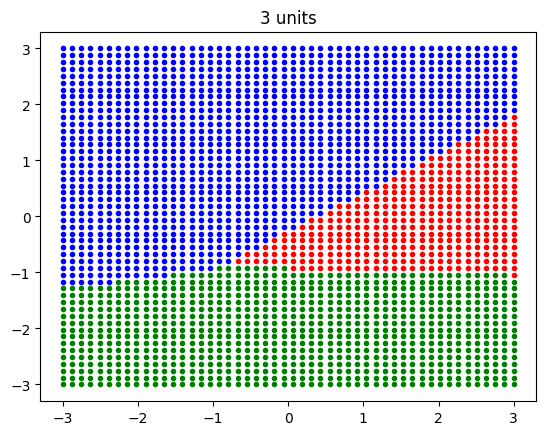

Done!


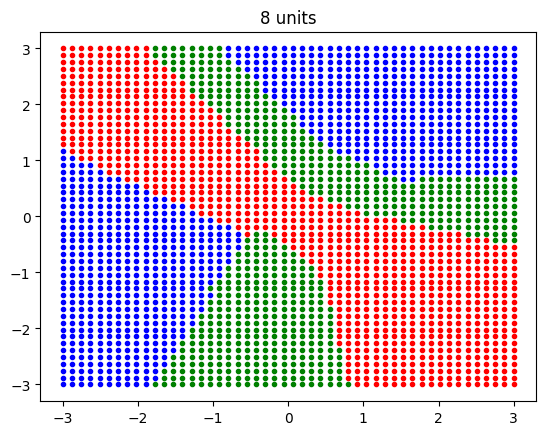

Done!


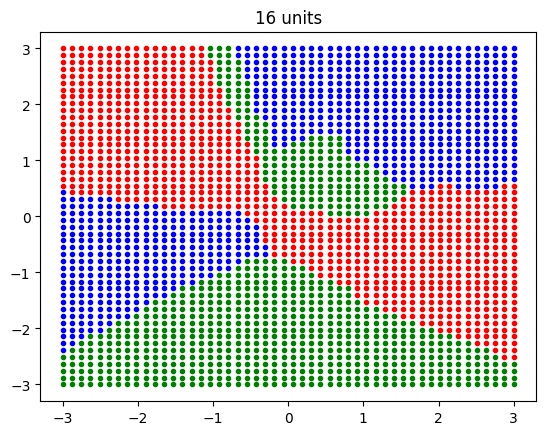

In [11]:
# Number of units tests
############# 3 units
NN = MLP()
numunits = 3
numlayers = 3
NN.add_layer('Hidden', dim_in=2, dim_out=numunits)
for i in range(numlayers-1):
    NN.add_layer('Hidden', dim_in=numunits, dim_out=numunits)

NN.add_layer('Output', dim_in=numunits, dim_out=3)
NN.add_layer('Loss', dim_in=3, dim_out=3)

NN.train(X, y, 100, 8, 0.0) #epochs, bsize, alpha

print("Done!")

# Plot decision boundaries
plt.figure()
plt.title("3 units")

decisionX1 = np.linspace(-3,3)
decisionX2 = np.linspace(-3,3)
for x1 in decisionX1:
    for x2 in decisionX2:
        curX = np.asarray([[x1],[x2]],dtype=float)
        yPred = NN.predict(curX)
        
        
        if yPred == 0: # yPred => 0
            plt.plot(x1,x2,"r.")
        elif yPred == 1: # yPred => 1
            plt.plot(x1,x2,"b.")
        else: # => 2
            plt.plot(x1,x2,"g.")

plt.show()

############# 8 units
NN = MLP()
numunits = 8
numlayers = 3
NN.add_layer('Hidden', dim_in=2, dim_out=numunits)
for i in range(numlayers-1):
    NN.add_layer('Hidden', dim_in=numunits, dim_out=numunits)

NN.add_layer('Output', dim_in=numunits, dim_out=3)
NN.add_layer('Loss', dim_in=3, dim_out=3)

NN.train(X, y, 100, 8, 0.0) #epochs, bsize, alpha

print("Done!")

# Plot decision boundaries
plt.figure()
plt.title("8 units")

decisionX1 = np.linspace(-3,3)
decisionX2 = np.linspace(-3,3)
for x1 in decisionX1:
    for x2 in decisionX2:
        curX = np.asarray([[x1],[x2]],dtype=float)
        yPred = NN.predict(curX)
        
        
        if yPred == 0: # yPred => 0
            plt.plot(x1,x2,"r.")
        elif yPred == 1: # yPred => 1
            plt.plot(x1,x2,"b.")
        else: # => 2
            plt.plot(x1,x2,"g.")

plt.show()


############# 16 units
NN = MLP()
numunits = 16
numlayers = 3
NN.add_layer('Hidden', dim_in=2, dim_out=numunits)
for i in range(numlayers-1):
    NN.add_layer('Hidden', dim_in=numunits, dim_out=numunits)

NN.add_layer('Output', dim_in=numunits, dim_out=3)
NN.add_layer('Loss', dim_in=3, dim_out=3)

NN.train(X, y, 100, 8, 0.0) #epochs, bsize, alpha

print("Done!")

# Plot decision boundaries
plt.figure()
plt.title("16 units")

decisionX1 = np.linspace(-3,3)
decisionX2 = np.linspace(-3,3)
for x1 in decisionX1:
    for x2 in decisionX2:
        curX = np.asarray([[x1],[x2]],dtype=float)
        yPred = NN.predict(curX)
        
        
        if yPred == 0: # yPred => 0
            plt.plot(x1,x2,"r.")
        elif yPred == 1: # yPred => 1
            plt.plot(x1,x2,"b.")
        else: # => 2
            plt.plot(x1,x2,"g.")

plt.show()

Done!


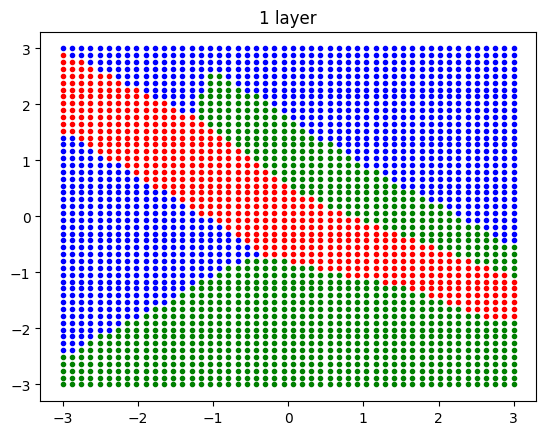

Done!


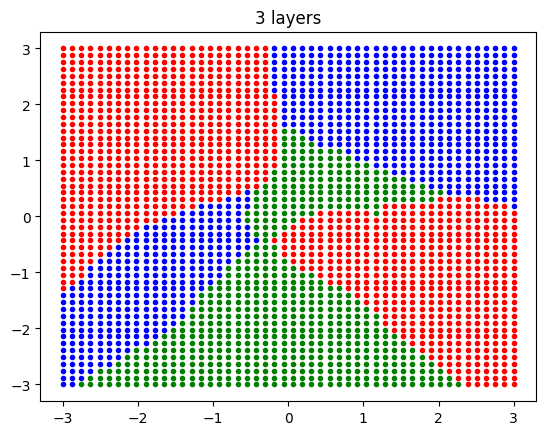

In [12]:
# Number of layers tests
############# 1 layer
NN = MLP()
numunits = 8
numlayers = 1
NN.add_layer('Hidden', dim_in=2, dim_out=numunits)
for i in range(numlayers-1):
    NN.add_layer('Hidden', dim_in=numunits, dim_out=numunits)

NN.add_layer('Output', dim_in=numunits, dim_out=3)
NN.add_layer('Loss', dim_in=3, dim_out=3)

NN.train(X, y, 100, 8, 0.0) #epochs, bsize, alpha

print("Done!")

# Plot decision boundaries
plt.figure()
plt.title("1 layer")

decisionX1 = np.linspace(-3,3)
decisionX2 = np.linspace(-3,3)
for x1 in decisionX1:
    for x2 in decisionX2:
        curX = np.asarray([[x1],[x2]],dtype=float)
        yPred = NN.predict(curX)
        
        
        if yPred == 0: # yPred => 0
            plt.plot(x1,x2,"r.")
        elif yPred == 1: # yPred => 1
            plt.plot(x1,x2,"b.")
        else: # => 2
            plt.plot(x1,x2,"g.")

plt.show()



############# 3 layers
NN = MLP()
numunits = 8
numlayers = 3
NN.add_layer('Hidden', dim_in=2, dim_out=numunits)
for i in range(numlayers-1):
    NN.add_layer('Hidden', dim_in=numunits, dim_out=numunits)

NN.add_layer('Output', dim_in=numunits, dim_out=3)
NN.add_layer('Loss', dim_in=3, dim_out=3)

NN.train(X, y, 100, 8, 0.0) #epochs, bsize, alpha

print("Done!")

# Plot decision boundaries
plt.figure()
plt.title("3 layers")

decisionX1 = np.linspace(-3,3)
decisionX2 = np.linspace(-3,3)
for x1 in decisionX1:
    for x2 in decisionX2:
        curX = np.asarray([[x1],[x2]],dtype=float)
        yPred = NN.predict(curX)
        
        
        if yPred == 0: # yPred => 0
            plt.plot(x1,x2,"r.")
        elif yPred == 1: # yPred => 1
            plt.plot(x1,x2,"b.")
        else: # => 2
            plt.plot(x1,x2,"g.")

plt.show()
        

Done!


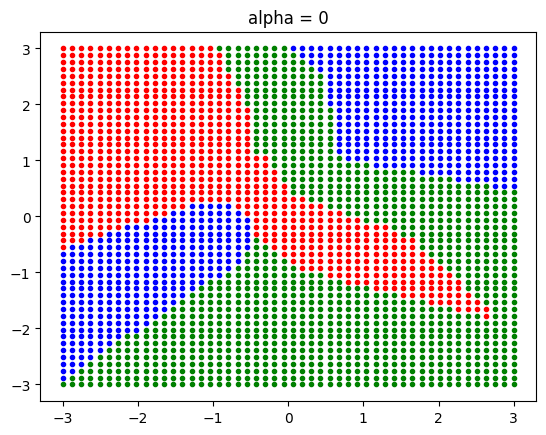

Done!


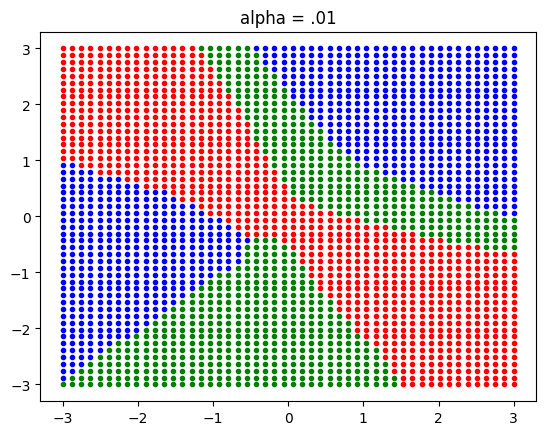

In [13]:
# Alpha test
############# alpha = 0
NN = MLP()
numunits = 8
numlayers = 3
NN.add_layer('Hidden', dim_in=2, dim_out=numunits)
for i in range(numlayers-1):
    NN.add_layer('Hidden', dim_in=numunits, dim_out=numunits)

NN.add_layer('Output', dim_in=numunits, dim_out=3)
NN.add_layer('Loss', dim_in=3, dim_out=3)

NN.train(X, y, 100, 8, 0.0) #epochs, bsize, alpha

print("Done!")

# Plot decision boundaries
plt.figure()
plt.title("alpha = 0")

decisionX1 = np.linspace(-3,3)
decisionX2 = np.linspace(-3,3)
for x1 in decisionX1:
    for x2 in decisionX2:
        curX = np.asarray([[x1],[x2]],dtype=float)
        yPred = NN.predict(curX)
        
        
        if yPred == 0: # yPred => 0
            plt.plot(x1,x2,"r.")
        elif yPred == 1: # yPred => 1
            plt.plot(x1,x2,"b.")
        else: # => 2
            plt.plot(x1,x2,"g.")

plt.show()



############# alpha = .01
NN = MLP()
numunits = 8
numlayers = 3
NN.add_layer('Hidden', dim_in=2, dim_out=numunits)
for i in range(numlayers-1):
    NN.add_layer('Hidden', dim_in=numunits, dim_out=numunits)

NN.add_layer('Output', dim_in=numunits, dim_out=3)
NN.add_layer('Loss', dim_in=3, dim_out=3)

NN.train(X, y, 100, 8, 0.01) #epochs, bsize, alpha

print("Done!")

# Plot decision boundaries
plt.figure()
plt.title("alpha = .01")

decisionX1 = np.linspace(-3,3)
decisionX2 = np.linspace(-3,3)
for x1 in decisionX1:
    for x2 in decisionX2:
        curX = np.asarray([[x1],[x2]],dtype=float)
        yPred = NN.predict(curX)
        
        
        if yPred == 0: # yPred => 0
            plt.plot(x1,x2,"r.")
        elif yPred == 1: # yPred => 1
            plt.plot(x1,x2,"b.")
        else: # => 2
            plt.plot(x1,x2,"g.")

plt.show()
        

In [14]:
## New Different Data

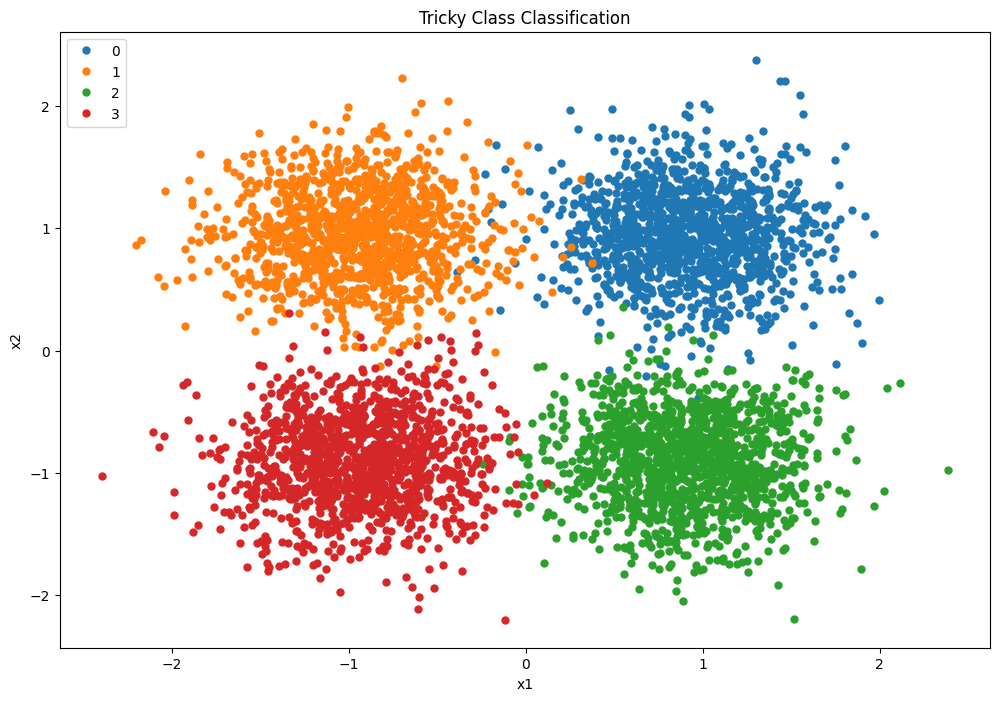

In [15]:
data2 = pd.DataFrame(np.zeros((5000, 3)), columns=['x1', 'x2', 'y'])

# Let's make up some noisy XOR data to use to build our binary classifier
for i in range(len(data.index)):
    x1 = random.randint(0,1)
    x2 = random.randint(0,1)
    if x1 == 1 and x2 == 1:
        y = 0
    elif x1 == 0 and x2 == 1:
        y = 1
    elif x1 == 1 and x2 == 0:
        y = 2
    else:
        y = 3
    x1 = 1.0 * x1 + 0.20 * np.random.normal()
    x2 = 1.0 * x2 + 0.20 * np.random.normal()
    data.iloc[i,0] = x1
    data.iloc[i,1] = x2
    data.iloc[i,2] = y
    
data.iloc[:,0] = (data.iloc[:,0] - data['x1'].mean()) / data['x1'].std()
data.iloc[:,1] = (data.iloc[:,1] - data['x2'].mean()) / data['x2'].std()
        
data.head()

cols = data.shape[1]
X = data.iloc[:,0:cols-1]
y = data.iloc[:,cols-1:cols]

X = np.matrix(X.values)
y = np.matrix(y.values)

plot_data(X, y)

trainX = X[0:3000,:]
valX = X[3001:4000,:]
testX = X[4001:,:]

trainY = y[0:3000]
valY = y[3001:4000]
testY = y[4001:]

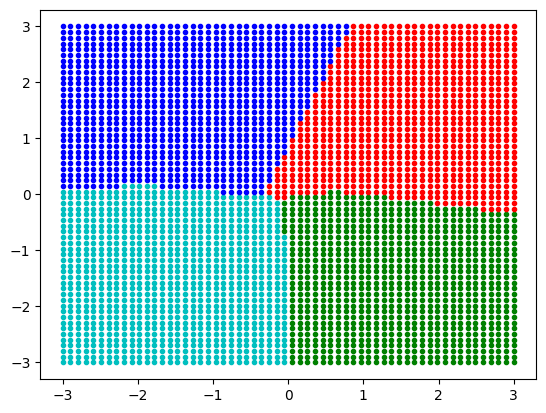

Accuracy: 0.986986986986987


In [17]:
NN2 = MLP()
numunits = 8
numlayers = 3
NN2.add_layer('Hidden', dim_in=2, dim_out=numunits)
for i in range(numlayers-1):
    NN2.add_layer('Hidden', dim_in=numunits, dim_out=numunits)

NN2.add_layer('Output', dim_in=numunits, dim_out=4)
NN2.add_layer('Loss', dim_in=4, dim_out=4)

NN2.train(trainX, trainY, 100, 8, 0.01,True,valX,valY) #epochs, bsize, alpha

# Plot decision boundaries
plt.figure()

decisionX1 = np.linspace(-3,3,60)
decisionX2 = np.linspace(-3,3,60)
for x1 in decisionX1:
    for x2 in decisionX2:
        curX = np.asarray([[x1],[x2]],dtype=float)
        yPred = NN2.predict(curX)
        
        
        if yPred == 0: # yPred => 0
            plt.plot(x1,x2,"r.")
        elif yPred == 1: # yPred => 1
            plt.plot(x1,x2,"b.")
        elif yPred == 2: # => 2
            plt.plot(x1,x2,"g.")
        elif yPred == 3:
            plt.plot(x1,x2,"c.")

plt.show()

correct = 0
totalNum = 0
# Get accuracy
for i in range(len(testX)):
    totalNum+=1

    curX = testX[i].transpose()
    curY = testY[i]
    yPred = NN2.predict(curX)
    
    if(yPred == curY):
        correct += 1

print("Accuracy:",correct/totalNum)
        
        
        
        
